## Deep Learning

## Traffic Sign Recognition Classifier

A convolutional neural network that trains on a set of traffic sign images and their labels to be able to predict the correct classification for a “new” traffic sign image.

The first step was to get familiar with the data. This done via the load_pickled_data function that generates a set of (X, y) data sets for training, testing and validation.

---
## Step 0: Load The Data

In [1]:
import os
os.getcwd()
test_file = "./../traffic-signs-data/train.p"
#print(test_file)

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./../traffic-signs-data/train.p"
validation_file= "./../traffic-signs-data/valid.p"
testing_file = "./../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

A basic data summary is presented below. Python and numpy methods were used to calculate the data summary.

### Basic Summary of the Data Set Using Python and Numpy

In [3]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of a traffic sign image?
image_shape = X_train[0].shape

# Unique classes/labels in the dataset.
import csv

with open('signnames.csv', 'r') as csvfile:
    
    reader = csv.DictReader(csvfile)
    labels_dict = {}
    for row in reader:
        k = row['ClassId']
        v = row['SignName']
        labels_dict.update({k: v})
        
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualization of the German Traffic Signs Dataset using the pickled file(s). 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.


In [4]:
### Data exploration and visualization code:

import matplotlib.pyplot as plt
import scipy as sp
import cv2

# Visualizations will be shown in the notebook.
%matplotlib inline

# Viewing the images in the dataset
def data_show(feat, labels, label_dict, seed):
    
    no_of_images = 15
    np.random.seed(seed)
    rand_arr = np.random.randint((n_train-1), size = no_of_images)
            
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    for i in range(no_of_images):
        image = X_train[rand_arr[i]]
        key = y_train[rand_arr[i]]
        fig_title = str(key) + ' ' + labels_dict[str(key)]
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(fig_title, fontSize=12)

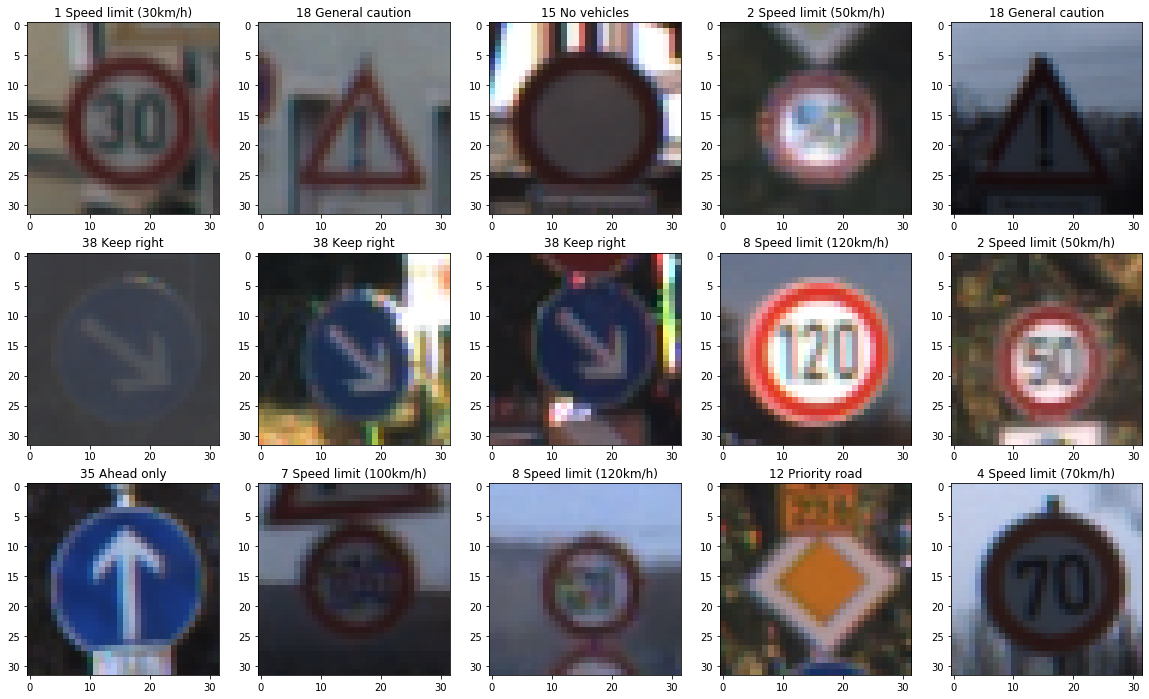

In [5]:
data_show(X_train, y_train, labels_dict, seed=0)

### Viewing the images in grayscale

In [6]:
def data_show_gray(feat, labels, label_dict, seed):
    
    no_of_images = 15
    np.random.seed(seed)
    rand_arr = np.random.randint((n_train-1), size = no_of_images)
            
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    for i in range(no_of_images):
        
        image = X_train[rand_arr[i]]
        key = y_train[rand_arr[i]]
        fig_title = str(key) + ' ' + labels_dict[str(key)]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax = axes[i]
        ax.imshow(gray, cmap='gray')
        ax.set_title(fig_title, fontSize=12)

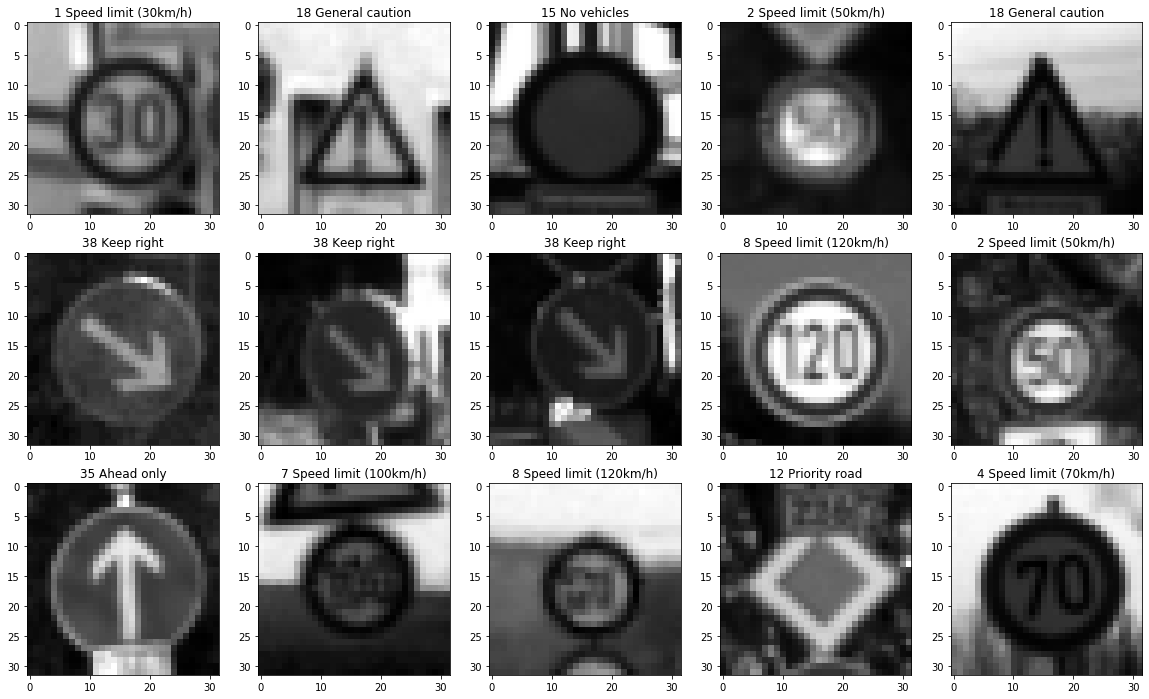

In [7]:
data_show_gray(X_train, y_train, labels_dict, seed=0)

Viewing in grayscale helped in improving the clarity of some of the images such as the one in the 2nd row and 1st column. 

### Distribution of the images in the dataset  

In [8]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8),
 array([ 180, 1980, 2010, 1260, 1770, 1650,  360, 1290, 1260, 1320, 1800,
        1170, 1890, 1920,  690,  540,  360,  990, 1080,  180,  300,  270,
         330,  450,  240, 1350,  540,  210,  480,  240,  390,  690,  210,
         599,  360, 1080,  330,  180, 1860,  270,  300,  210,  210],
       dtype=int64))

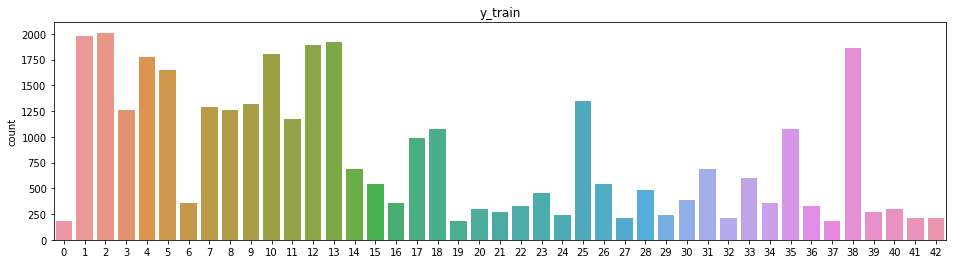

In [9]:
import seaborn as sns
plt.figure(figsize=(16,4))
plt.title('y_train')
sns.countplot(y_train)

The histogram shows that some of the traffic signals may not be adequately represented, having lesser than 200 test imags vis-a-vis the maximum at approximately 2000 images, indicating **data imbalance**. These traffic signals will be augmented in the preprocessing stage.

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. The model was trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set 

Training a convolutional neural network on raw images will probably lead to bad classification performances (Pal & Sudeep, 2016). The preprocessing is also important to speed up training (for instance, centering and scaling techniques, see Lecun et al., 2012; see 4.3).

A popular method to solve imbalance problem is data augmentation which increases the apparent number of samples in minority classes to balance between majority classes and minority classes by applying the geometric transformations or adding noise to training samples.

Preprocessing techniques used to sythesize image data for augmentation include:
1. Change contrast
2. Rotate images
3. Add noise / blur

### Preprocessing and augmentation of image data

In [10]:
class_seq, class_count = np.unique(y_train, return_counts=True)
#print(class_seq[1], class_count[1])
min_images = np.max(class_count) * 0.6

(32, 32, 3)

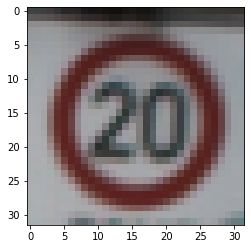

In [11]:
img = X_train[10132]
plt.imshow(img)
img.shape

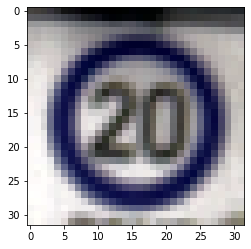

In [12]:
### cropping
#crop_img = img[8: 26, 8: 26]
#plt.imshow(crop_img)

### grayscale
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
#print(gray.shape)

#plt.contour(gray, [30, 100])
#plt.imshow(gray, cmap='gray')

### rotate
#img_15deg = sp.ndimage.rotate(img, 15, reshape=True)
#plt.imshow(img_15deg)

### blur image
#blur_img = sp.ndimage.gaussian_filter(img, sigma=0.5)
#plt.imshow(blur_img)

# Contrast
# Convert to YUV
image_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
# Apply histogram equalization
image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
# Convert to RGB
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
# Show image
plt.imshow(image_rgb)#, plt.axis("off")
plt.show()

### Data Augmentation and balancing the distribution

In [13]:
# Identify classes to augment
def augm_class(class_count, min_images):
    
    augm_classes = []
    for i in range(len(class_count)):
    
        if class_count[i] < min_images:
            
            deficit = int(min_images - class_count[i])                
            if deficit < 4:
                
                deficit = 4
                
            augm_classes.append((i, deficit))
            
    return augm_classes
    
# Create images for the classes    
def process_image(X_train, y_train, augm_classes):
    
    augm_img = []
    augm_label = []
    for i, j in augm_classes:
        
        list_img = np.where(y_train == i)
        seed = 0
        while j != 0:
            
            np.random.seed(seed)
            idx = np.random.randint(len(list_img[0]), size = 1)
            img_idx = int(list_img[0][idx])
            img = X_train[img_idx]
            
            # YUV enhancement
            image_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            augm_img.append(image_rgb)
            augm_label.append(i)
            j -= 1
            if j == 0:
                break
            
            # rotate 15 deg
            img_15deg = sp.ndimage.rotate(img, 15, reshape=False)
            augm_img.append(img_15deg)
            augm_label.append(i)
            j -= 1
            if j == 0:
                break
            #print("Rotated image: ", img_idx, ";  Class: ", i)
            
            # rotate -15 deg
            img_15deg = sp.ndimage.rotate(img, -15, reshape=False)
            augm_img.append(img_15deg)
            augm_label.append(i)
            j -= 1
            if j == 0:
                break
            #print("Rotated image: ", img_idx, ";  Class: ", i)
            
            # blur
            blur_img = sp.ndimage.gaussian_filter(img, sigma=0.5)
            augm_img.append(blur_img)
            augm_label.append(i)
            j -= 1
            if j == 0:
                break
            #print("Blurred image: ", img_idx, ";  Class: ", i)
            
            seed += 1
        
        print("Completed Class: ", i)
    
    print("---------------------------")
    print("Data augmentation complete.")
    return np.array(augm_img), np.array(augm_label)

### Shuffle the training data

In [14]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [15]:
augm_images = augm_class(class_count, min_images)
X_augm, y_augm = process_image(X_train, y_train, augm_images)

Completed Class:  0
Completed Class:  6
Completed Class:  11
Completed Class:  14
Completed Class:  15
Completed Class:  16
Completed Class:  17
Completed Class:  18
Completed Class:  19
Completed Class:  20
Completed Class:  21
Completed Class:  22
Completed Class:  23
Completed Class:  24
Completed Class:  26
Completed Class:  27
Completed Class:  28
Completed Class:  29
Completed Class:  30
Completed Class:  31
Completed Class:  32
Completed Class:  33
Completed Class:  34
Completed Class:  35
Completed Class:  36
Completed Class:  37
Completed Class:  39
Completed Class:  40
Completed Class:  41
Completed Class:  42
---------------------------
Data augmentation complete.


### Size of augmented data

In [16]:
print(X_augm.nbytes)
X_augm[0].shape

69860352


(32, 32, 3)

### Visualize augmented data

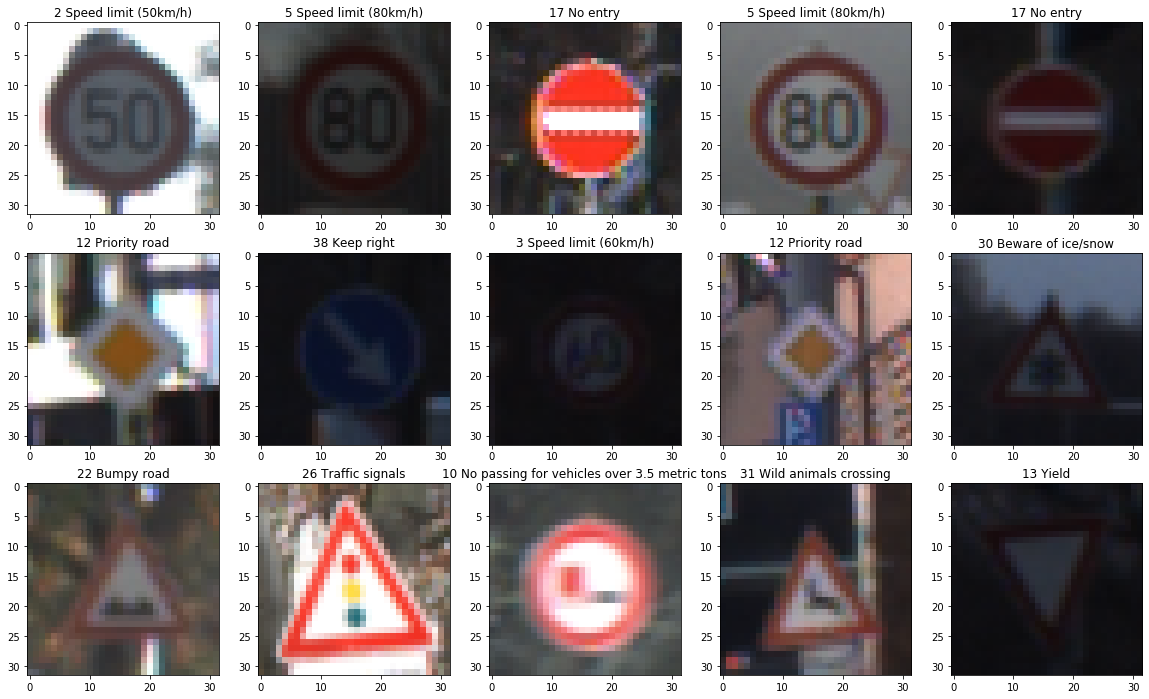

In [17]:
data_show(X_augm, y_augm, labels_dict, seed=10)

### Data distribution after augmentation

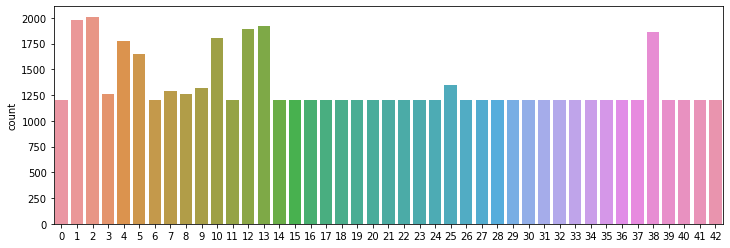

In [18]:
plt.figure(figsize=(12,4))
sns.countplot(np.concatenate((y_train, y_augm)))

The difference between the original data set and the augmented data set is the following - the under represented classes are now adequate in number, from the previous ratio of 1:9 to 2:3.

### Concatenate training and augmeted data

In [19]:
X_train = np.concatenate((X_train, X_augm), axis=0)
y_train = np.concatenate((y_train, y_augm))

### Normalizing the data
The data was normalized using mean and standard deviation.

In [20]:
def normalize(image):
    n = image / 255.0
    mean = n.mean(axis=(0,1,2))
    std = n.std(axis=(0,1,2))
    n = (n - mean)/ std
    return n

In [21]:
normalized = normalize(img)
#plt.imshow(normalized)
#print(normalized)

In [22]:
X_train, X_valid, X_test = map(normalize, [X_train, X_valid, X_test])

## Model Architecture

### Dimensionality
Calculating the number of neurons of each layer in the CNN

Given:
1. input layer has a width of W and a height of H
2. convolutional layer has a filter size F
3. stride of S
4. padding of P
5. the number of filters K,
the following formula gives the width of the next layer: `W_out =[ (W−F+2P)/S] + 1`

The output height would be `H_out = [(H-F+2P)/S] + 1`

And the output depth would be equal to the number of filters `D_out = K`

The output volume would be `W_out * H_out * D_out`

### TensorFlow Convolution Layer (version = 1.15)

`# Output depth
k_output = 64`

`# Image Properties
image_width = 10
image_height = 10
color_channels = 3`

`# Convolution filter
filter_size_width = 5
filter_size_height = 5`

`# Input/Image
input = tf.placeholder(
    tf.float32,
    shape=[None, image_height, image_width, color_channels])`

`# Weight and bias
weight = tf.Variable(tf.truncated_normal(
    [filter_size_height, filter_size_width, color_channels, k_output]))
bias = tf.Variable(tf.zeros(k_output))`

`# Apply Convolution
conv_layer = tf.nn.conv2d(input, weight, strides=[1, 2, 2, 1], padding='SAME')`

`# Add bias
conv_layer = tf.nn.bias_add(conv_layer, bias)`

`# Apply activation function
conv_layer = tf.nn.relu(conv_layer)`

### Implementation of a modified LeNet-5
Implementing a modified form of the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
This architecture accepts a 32x32x3 RGB image as input.

### Architecture
| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x3 RGB image   							| 
| Convolution	     	| 1x1 stride, valid padding, outputs 28x28x32 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride, outputs 14x14x32 					|
| Convolution		    | 1x1 stride, valid padding, outputs 10x10x64	|
| RELU					| 												|
| Max pooling			| 2x2 stride, outputs 5x5x64					|
| Fully connected		| Input = 1600. Output = 120.					|
| RELU					|												|
| Dropout				|												|
| Fully connected		| 2x2 stride, outputs 14x14x32 					|
| RELU					|												|
| Dropout				|												|
| Fully connected 		| Output layer. Input = 84. Output = 43.		|

### Output
Returns the result of the 2nd fully connected layer.

### Set up TensorFlow (version = 1.15)

In [23]:
import tensorflow as tf

In [24]:
# Create wrappers

# Conv2d wrapper with bias and relu activation
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# MaxPool 2D wrapper
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

In [25]:
# Create model
from tensorflow.contrib.layers import flatten

def m_LeNet(x, weights, biases, dropout):    
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = maxpool2d(conv1, k=2)
    
    # Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x64. Output = 1600.
    conv2_flat = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120.    
    fc1 = tf.add(tf.matmul(conv2_flat, weights['wfc1']), biases['bfc1'])
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wfc2']), biases['bfc2'])
    # Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Layer 5: Fully Connected. Output layer. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

In [26]:
# Training parameters
learning_rate = 0.001
epochs = 10
batch_size = 256

# Network parameters
dropout = 0.75

# tf Graph input
# x is a placeholder for a batch of input images.
# y is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [27]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Store layers weight & bias
weights = {
    # 5x5 conv, 3 input, 32 outputs
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma)),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma)),
    # fully connected, 5*5*64 inputs, 120 outputs
    'wfc1': tf.Variable(tf.truncated_normal(shape=(5*5*64, 120), mean = mu, stddev = sigma)),
    # fully connected, 120 inputs, 84 outputs
    'wfc2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
    # 1024 inputs, 43 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros(32)),
    'bc2': tf.Variable(tf.zeros(64)),
    'bfc1': tf.Variable(tf.zeros(120)),
    'bfc2': tf.Variable(tf.zeros(84)),
    'out': tf.Variable(tf.zeros(n_classes))}

### Training Pipeline

In [28]:
# Construct model
logits = m_LeNet(x, weights, biases, keep_prob)
#prediction = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Define loss and optimizer
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Model Evaluation

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        #How is this different?
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, 
                                                           y: batch_y,
                                                           keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Train the Model
The training data was run through the training pipeline to train the model. Before each epoch, the raining set was shuffled set. The loss and accuracy of the validation set were measured after each epoch.

The model was saved after training.

In [30]:
### Check GPU is available

#from __future__ import absolute_import, division, print_function, unicode_literals

#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [31]:
with tf.Session() as sess:
    
    # Run the initializer
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(epochs):
        
        X_tr, y_tr = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            
            end = offset + batch_size
            batch_x, batch_y = X_tr[offset:end], y_tr[offset:end]
        
            if len(batch_x): # As BATCH_SIZE is not a divisor of X_train_split it raises an error if this is not checked
                sess.run(training_operation, feed_dict={x: batch_x, 
                                                        y: batch_y,
                                                        keep_prob: dropout})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'm_lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.902
Validation Accuracy = 0.846

EPOCH 2 ...
Training Accuracy = 0.972
Validation Accuracy = 0.926

EPOCH 3 ...
Training Accuracy = 0.986
Validation Accuracy = 0.932

EPOCH 4 ...
Training Accuracy = 0.992
Validation Accuracy = 0.953

EPOCH 5 ...
Training Accuracy = 0.994
Validation Accuracy = 0.951

EPOCH 6 ...
Training Accuracy = 0.996
Validation Accuracy = 0.954

EPOCH 7 ...
Training Accuracy = 0.998
Validation Accuracy = 0.963

EPOCH 8 ...
Training Accuracy = 0.997
Validation Accuracy = 0.954

EPOCH 9 ...
Training Accuracy = 0.999
Validation Accuracy = 0.960

EPOCH 10 ...
Training Accuracy = 0.999
Validation Accuracy = 0.966

Model saved


In [32]:
#load the model
with tf.Session() as sess:
    # Restore model from disk.
    saver.restore(sess, "m_lenet")
    print("Model restored.")
    print("---------------")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

INFO:tensorflow:Restoring parameters from m_lenet
Model restored.
---------------
Test Accuracy = 0.955



---

## Step 3: Test Model on New Images

To check how the model is working, five pictures of German traffic signs were downloaded from the web and the model was used to predict the traffic sign type.


### Load and Output the Images

In [33]:
# Create list of images
urls = [
    r'https://i0.wp.com/verkehrsschilder-discounter.de/wp-content/uploads/2019/11/IBC-vorschriftzeichen-vz-209-30-vorgeschriebene-fahrtrichtung-geradeausra600mm-2.jpg',
    r'https://cdn.pixabay.com/photo/2019/06/29/07/35/shield-4305616_960_720.jpg',
    r'http://bicyclegermany.com/Images/Laws/Arterial.jpg',
    r'https://alpina-farben.de/blog/wp-content/uploads/2018/05/right-of-way-809137_19201.jpg',
    r'https://i1.wp.com/verkehrsschilder-discounter.de/wp-content/uploads/2019/11/IGW-vorschriftzeichen-vz-274-50-auch-274-55-zulaessige-hoechstgeschwindigkeit-ra-600-mm-1.jpg'
]

y_true = ['35', '11', '12', '13', '2']

### Download and display images

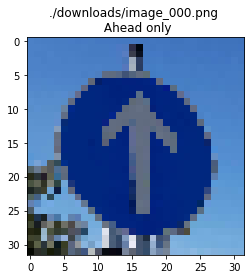

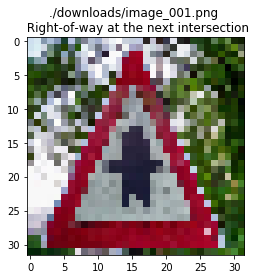

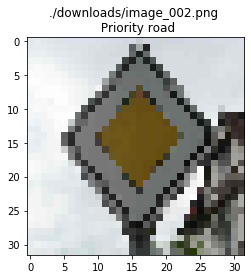

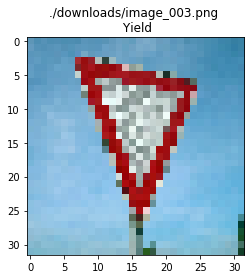

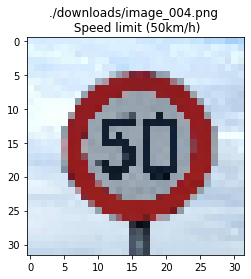

In [34]:
import requests

download_path = './downloads/'
X_downloaded = []
for i, url in enumerate(urls):
    
    fname = download_path + f'image_{i:03d}.png'
    resp = requests.get(url, stream=True).raw
    image = np.asarray(bytearray(resp.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    cv2.imwrite(fname, image)
    X_downloaded.append(image)
    plt.imshow(image) 
    plt.title(fname + ' \n ' + labels_dict[y_true[i]])
    plt.show()
    

### Predict the Sign Type for Each Image

In [35]:
### Run the predictions and use the model to output the prediction for each image.
### Pre-process the images with the same pre-processing pipeline used earlier.

### Preprocess data and normalize

In [36]:
y_true = list(map(int, y_true))
y_true = np.array(y_true)

In [37]:
X_downloaded = np.array(list(X_downloaded))

In [38]:
X_downloaded_n = list(map(normalize, X_downloaded))

In [39]:
X_downloaded_n = np.array(X_downloaded_n)
X_downloaded_n.shape
len(X_downloaded_n)

5

### Run the prediction

In [40]:
prediction = tf.nn.softmax(logits)

In [41]:
def predict(X_data):
#def predict(X_data, y_data):
    sess = tf.get_default_session()
    preds = sess.run(prediction, feed_dict={x: X_data, keep_prob: 1.0})
    return preds

In [42]:
with tf.Session() as sess:
    saver.restore(sess, 'm_lenet')
    preds = predict(X_downloaded_n)
    pred_labels = np.argmax(preds, axis = -1)

INFO:tensorflow:Restoring parameters from m_lenet


In [43]:
pred_labels

array([35, 11, 12, 13,  2], dtype=int64)

In [44]:
#Display images. Display true and predicted labels for each image.
def plot_images(images, true_lbl, pred_lbl, title=None):
    """
    Create figure with 1x5 sub-plots.
    :param images: array of images to be plotted, (12, img_h*img_w)
    :param true_lbl: corresponding true labels (5,)
    :param pred_lbl: corresponding true labels (5,)
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        ax_title = "True: {0}, Pred: {1}".format(true_lbl[i], pred_lbl[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

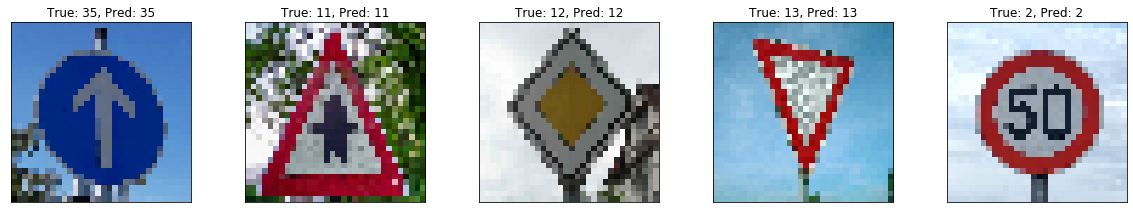

In [45]:
plot_images(X_downloaded, y_true, pred_labels)

### Analyze Performance

In [46]:
#load the model
with tf.Session() as sess:
    # Restore model from disk.
    saver.restore(sess, "m_lenet")
    print("Model restored.")
    print("---------------")
    test_accuracy = evaluate(X_downloaded_n, y_true)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

INFO:tensorflow:Restoring parameters from m_lenet
Model restored.
---------------
Test Accuracy = 1.000



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, the model's softmax probabilities were displayed to show the **certainty** of the model's predictions.  The output was limited to the top 5 probabilities for each image. 

In [47]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

In [48]:
# Sort and return top 5 probabilities for the prediction
def top_k(x, k):
    top_k_index = np.argsort(x)[::-1][:k]
    return top_k_index, x[top_k_index]

In [49]:
 # Plot the predictions along with the input image and label
def plot_topk(images, preds, k=5):
    
    #plt.figure(1, figsize=(12,4*len(images)))
    for idx in range(k):
        
        image = images[idx]
        pred  = preds[idx]
        topk_label, topk_prob = top_k(pred, k)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,3))
        ax1.imshow(image)
        ax1.set_title("Downloaded image #{}".format(idx+1))
        ax1.set_xticks([])
        ax1.set_yticks([])
        
        labels =[]
        for i in range(k):
            
            label = labels_dict[str(topk_label[i])] + "\n[{}]".format(topk_prob[i])
            labels.append(label)
            
        sns.barplot(x=topk_prob, y=labels, orient="h", ax=ax2)


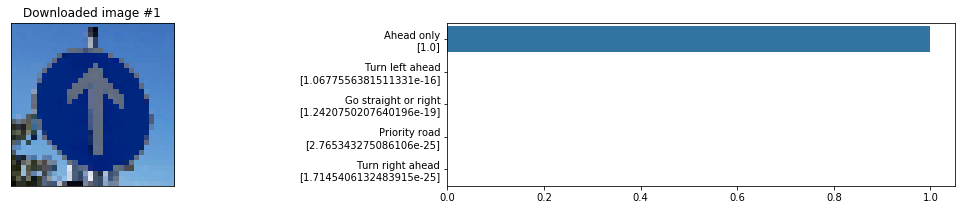

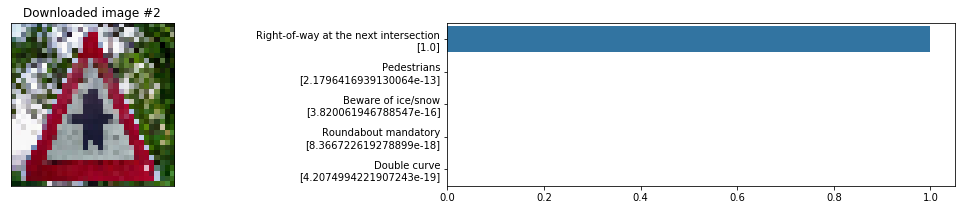

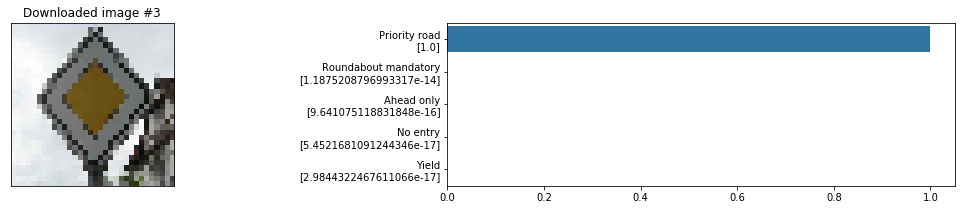

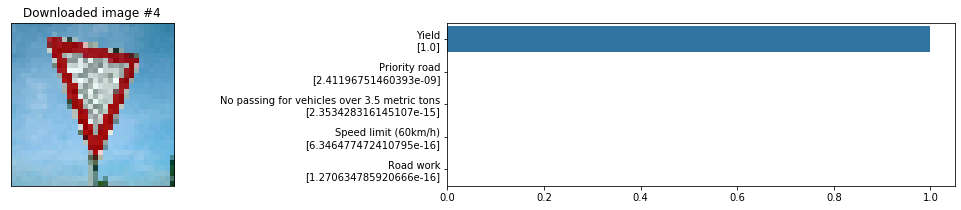

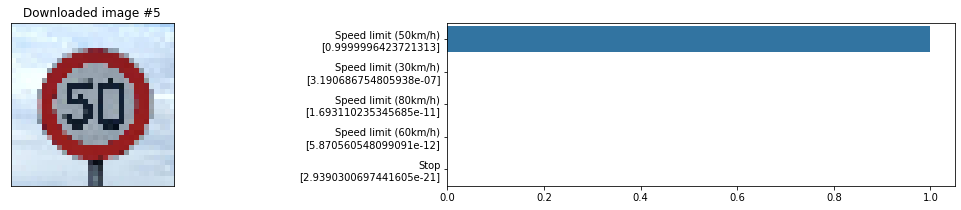

In [50]:
plot_topk(X_downloaded, preds, k=5)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [51]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")